# RNN Tutorial

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/Polish.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Irish.txt', 'data/names/Portuguese.txt', 'data/names/Korean.txt', 'data/names/French.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/Italian.txt']
Slusarski


Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [3]:
import jittor

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = jittor.zeros((1, n_letters))
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = jittor.zeros((len(line), 1, n_letters))
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

[i 0310 12:14:29.402351 80 log.cc:351] Load log_sync: 1
[i 0310 12:14:29.424719 80 compiler.py:955] Jittor(1.3.6.10) src: /home/lzyhha/anaconda3/envs/jdet/lib/python3.8/site-packages/jittor
[i 0310 12:14:29.426860 80 compiler.py:956] g++ at /usr/bin/g++(9.4.0)
[i 0310 12:14:29.427169 80 compiler.py:957] cache_path: /home/lzyhha/.cache/jittor/jt1.3.6/g++9.4.0/py3.8.13/Linux-5.15.0-6xe4/12thGenIntelRCx51/default
[i 0310 12:14:29.429421 80 __init__.py:411] Found nvcc(11.7.64) at /usr/local/cuda-11.7/bin/nvcc.
[i 0310 12:14:29.455640 80 __init__.py:411] Found gdb(20.04.1) at /usr/bin/gdb.
[i 0310 12:14:29.458277 80 __init__.py:411] Found addr2line(2.34) at /usr/bin/addr2line.
[i 0310 12:14:29.512277 80 compiler.py:1010] cuda key:cu11.7.64_sm_86
[i 0310 12:14:29.588093 80 __init__.py:227] Total mem: 62.58GB, using 16 procs for compiling.
[i 0310 12:14:29.649941 80 jit_compiler.cc:28] Load cc_path: /usr/bin/g++
[i 0310 12:14:29.733403 80 init.cc:62] Found cuda archs: [86,]
[i 0310 12:14:29.7

jt.Var([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
         0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
         0. 0. 0. 0. 0. 0. 0. 0. 0.]], dtype=float32)
[5,1,57,]


### Creating the Network
Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very “pure” way, as regular feed-forward layers.

This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

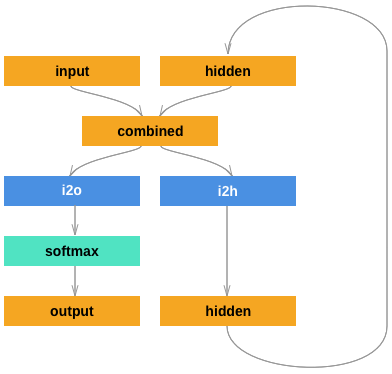

In [4]:
import jittor.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def execute(self, input, hidden):
        combined = jittor.concat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = jittor.nn.log_softmax(output)
        return output, hidden

    def initHidden(self):
        return jittor.zeros((1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [5]:
input = letterToTensor('A')
hidden = jittor.zeros((1, n_hidden))

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [6]:
input = lineToTensor('Albert')
hidden = jittor.zeros((1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(jittor.exp(output))

jt.Var([[0.05193255 0.0558621  0.05383034 0.05439388 0.06081381 0.05569347
         0.05434854 0.05607878 0.05579849 0.05655409 0.054328   0.05379442
         0.05420329 0.05561821 0.06365225 0.05299544 0.05167997 0.0584224 ]], dtype=float32)


As you can see the output is a <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).

### Preparing for Training
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 14)


We will also want a quick way to get a training example (a name and its language):

In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = jittor.array([all_categories.index(category)]).long()
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Fourakis
category = Korean / line = Yu
category = Portuguese / line = Duarte
category = Czech / line = Uerling
category = German / line = Dirchs
category = Irish / line = O'Mahony
category = Japanese / line = Aoki
category = German / line = Maier
category = Portuguese / line = Belo
category = Arabic / line = Tahan


### Training the Network
Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [9]:
def criterion(prediction, target):
    target = target.broadcast(prediction, [1])
    target = target.index(1) == target
    target = target.float()

    loss =  - target * prediction
    loss = loss.sum(dim=1).mean()

    return loss

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [10]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
for p in rnn.parameters():
    p.start_grad()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # Add parameters' gradients to their values, multiplied by learning rate
    grads = jittor.grad(loss, rnn.parameters(), retain_graph=False)
    for i, p in enumerate(rnn.parameters()):
        grad = grads[i].stop_grad()
        with jittor.no_grad():
            p.update(p - learning_rate * grad)
        p.start_grad()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.3420 Cardona / Japanese ✗ (Spanish)
10000 10% (0m 7s) 2.4637 Santana / Japanese ✗ (Portuguese)
15000 15% (0m 10s) 2.6962 Skeril / Portuguese ✗ (Czech)
20000 20% (0m 12s) 2.1655 Cablikova / Japanese ✗ (Czech)
25000 25% (0m 15s) 2.6115 Yasui / Arabic ✗ (Japanese)
30000 30% (0m 18s) 0.3214 Eliopoulos / Greek ✓
35000 35% (0m 20s) 2.2703 Feld / Scottish ✗ (German)
40000 40% (0m 23s) 0.9056 Ryom / Korean ✓
45000 45% (0m 26s) 2.0765 Tennant / German ✗ (English)
50000 50% (0m 28s) 2.1141 Santiago / Portuguese ✗ (Spanish)
55000 55% (0m 31s) 3.2243 Klemper / German ✗ (Czech)
60000 60% (0m 33s) 0.2950 Markhinin / Russian ✓
65000 65% (0m 36s) 4.5999 Tsoumada / Japanese ✗ (Greek)
70000 70% (0m 38s) 2.1037 Trampota / Spanish ✗ (Czech)
75000 75% (0m 41s) 1.5239 Han / Chinese ✗ (Vietnamese)
80000 80% (0m 44s) 3.0632 Kilshaw / Arabic ✗ (English)
85000 85% (0m 46s) 0.7909 Abaroa / Spanish ✓
90000 90% (0m 50s) 7.7245 Yam / Chinese ✗ (Russian)
95000 95% (0m 55s) 0.1405 Dang / Vietnamese 

### Plotting the Results
Plotting the historical loss from all_losses shows the network learning:

/home/lzyhha/anaconda3/envs/jdet/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/lzyhha/anaconda3/envs/jdet/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


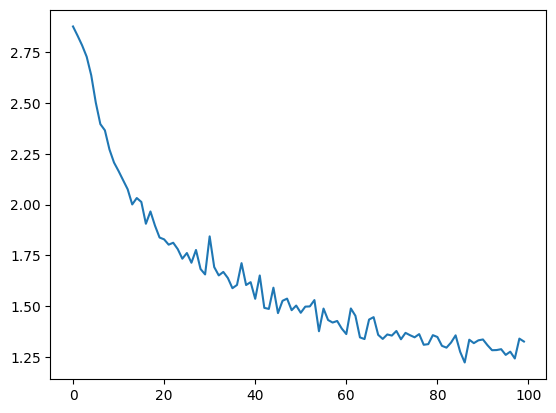

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

/tmp/ipykernel_435858/2335053960.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_435858/2335053960.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


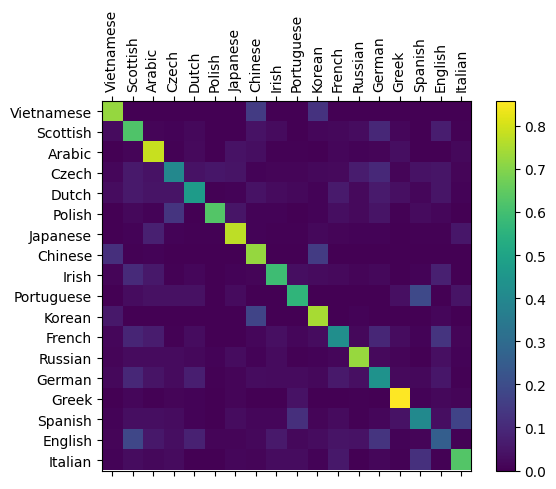

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = jittor.zeros((n_categories, n_categories))
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

### Running on User Input

In [14]:
import math
import numpy as np

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with jittor.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Hou')


> Dovesky
(0.61) Russian
(0.25) Czech
(0.08) English

> Jackson
(0.91) Scottish
(0.04) English
(0.02) Russian

> Hou
(0.38) Korean
(0.36) Chinese
(0.16) Vietnamese
